In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = 26, 10

# custom analysis tools
from analysis.scan import scan
from analysis.tools import plot_it
from analysis.tools import get_diff
from analysis.tools import extract_species

# useful python libraries
import pandas as pd

STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

# Functions

In [3]:
def get_its(scan, wl, pr, off = 9):
    
    x, it1 = plot_it(scan, wl, '15.0', plot = False, it = '0', power_ratio=pr)
    _, it2 = plot_it(scan, wl, '15.0', plot = False, it = '1', power_ratio=pr)
    _, it3 = plot_it(scan, wl, '15.0', plot = False, it = '2', power_ratio=pr)
    _, it4 = plot_it(scan, wl, '15.0', plot = False, it = '3', power_ratio=pr)

    return x-off, it1, it2, it3, it4

def get_treated_data(crystal, wl, irrad = True, pr = 10, SP=False):

    if SP == True:
        species = 'SP'
    elif SP == False:
        species = crystal.split('_')[0]
    if irrad == True:
        group = globals()[f'{species}_irrad']
    elif irrad == False:
        group = globals()[f'{species}_ctrl']


    # get the scans
    s1 = group['coll1'][crystal]
    s2 = group['coll2'][crystal]
    s3 = group['coll3'][crystal]
    s4 = group['coll4'][crystal]

    # for each scan get the iterations
    x1, s1_it1, s1_it2, s1_it3, s1_it4 = get_its(s1, wl, pr=pr)
    x2, s2_it1, s2_it2, s2_it3, s2_it4 = get_its(s2, wl, pr=pr)
    x3, s3_it1, s3_it2, s3_it3, s3_it4 = get_its(s3, wl, pr=pr)
    x4, s4_it1, s4_it2, s4_it3, s4_it4 = get_its(s4, wl, pr=pr)

    # add them up
    S1 = s1_it1 + s1_it2 + s1_it3 + s1_it4
    S2 = s2_it1 + s2_it2 + s2_it3 + s2_it4
    S3 = s3_it1 + s3_it2 + s3_it3 + s3_it4
    S4 = s4_it1 + s4_it2 + s4_it3 + s4_it4

    # run through muon filter
    thresh = 0.1
    X1, S1 = muon_filter([x1, S1], thresh = thresh)
    X2, S2 = muon_filter([x2, S2], thresh = thresh)
    X3, S3 = muon_filter([x3, S3], thresh = thresh)
    X4, S4 = muon_filter([x4, S4], thresh = thresh)
    
    return [X1, S1], [X2, S2], [X3, S3], [X4, S4]

def muon_filter(input, thresh=1,bins = 100):

    x        = input[0].copy()
    array = input[1].copy()
    
    hist = np.histogram(array, bins)
    muon_values = []

    for i in range(len(hist[0])):
        if   0 < hist[0][i] <= thresh:
            muon_values.append([hist[1][i], hist[1][i+1]])


    muon_indices = []
    # run through muon intervals
    for tup in muon_values:
        a = tup[0]; b = tup[1]

        # now loop the array to find this element
        for i in range(len(array)):
            if a <= array[i] <= b : 
                muon_indices.append(i)
    
    # clean muons
    for i in muon_indices:
            array[i-1] = np.nan
            array[i] = np.nan
            array[i+1] = np.nan
            
        
    return x, array

# LiF Data

In [10]:
pr = 11.75

# Irradiation group
LiF_irrad                = extract_species(path, 'LiF', ext='irrad') 
LiF_irrad_samples = ['LiF_B1_131', 'LiF_B2_145', 'LiF_B2_157', 'LiF_B2_158']

# control group
LiF_ctrl                     = extract_species(path, 'LiF', ext='ctrl') 
LiF_ctrl_samples      = ['LiF_B1_130', 'LiF_B2_143', 'LiF_B2_155']

# lif_agreement_2
x_la2, y_145_la2, y_157_la2 = np.load('agreement_lif_2.npy')

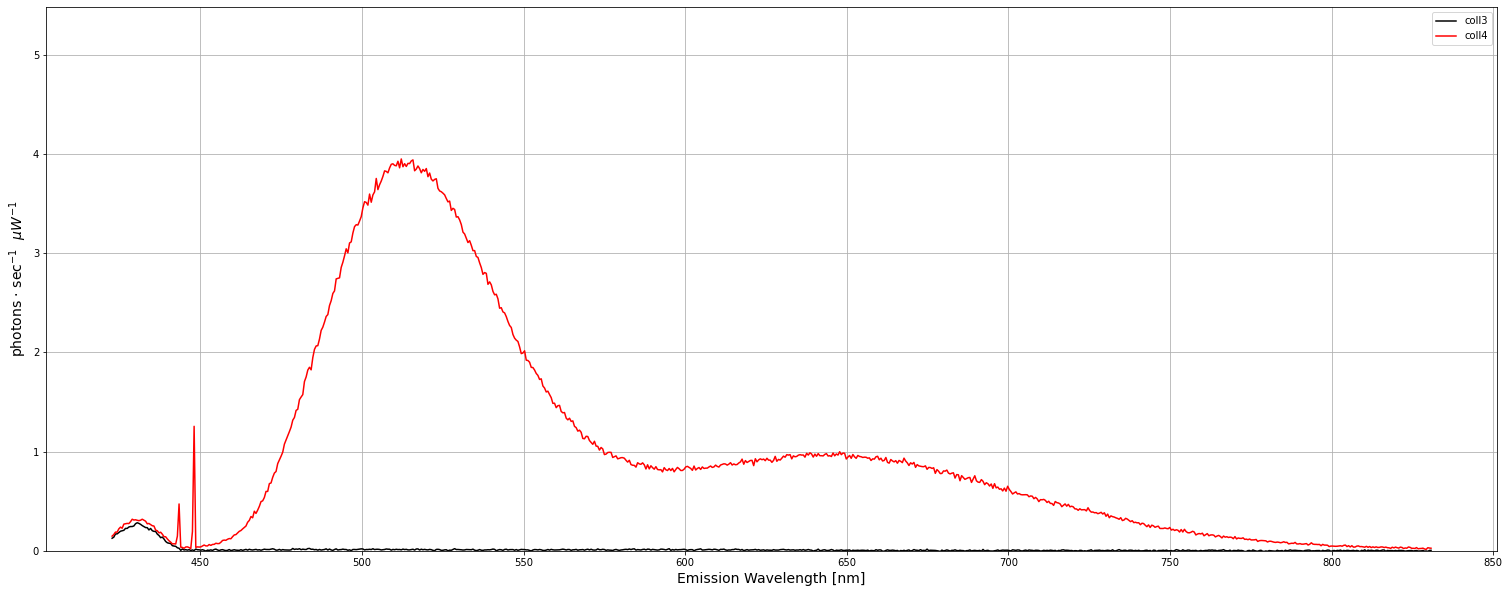

In [38]:
data = plot_it(LiF_irrad['coll3']['LiF_B2_157_B'], '435' , '15.0', label = 'coll3', color='black', power_ratio = pr, it = 0);
data = plot_it(LiF_irrad['coll4']['LiF_B2_157_B'], '435' , '15.0', label = 'coll4', color='red', power_ratio = pr,it = 0);

In [26]:
DATA_145 = get_treated_data('LiF_B2_145_B', '435', irrad = True, pr = 11.75, SP=False)
_, _, s3_145, s4_145 = DATA_145

DATA_157 = get_treated_data('LiF_B2_157_B', '435', irrad = True, pr = 11.75, SP=False)
_, _, s3_157, s4_157 = DATA_157

x_mn = s3_157[0]
y_145_mn = np.subtract(s4_145[1], s3_145[1])
y_157_mn = np.subtract(s4_157[1], s3_157[1])

Text(0, 0.5, 'Photons sec$^{-1} \\; \\mu W^{-1}$')

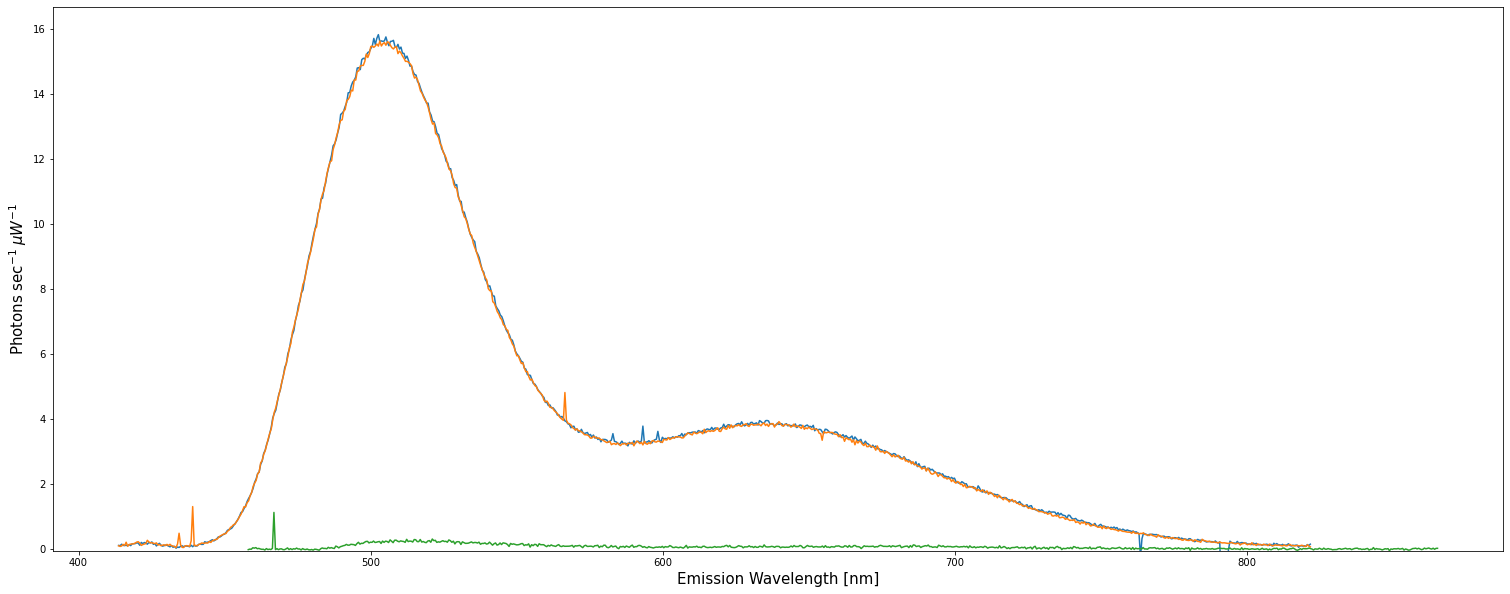

In [44]:
plt.plot(x_mn, y_145_mn)
plt.plot(x_mn, y_157_mn)
plt.plot(x_la2, y_157_la2)
plt.ylim(-0.05)
plt.xlabel('Emission Wavelength [nm]', fontsize = 15)
plt.ylabel(r'Photons sec$^{-1} \; \mu W^{-1}$', fontsize = 15)

In [40]:
np.trapz(y_145_la2, x_la2)

18.584129905382614

In [41]:
np.trapz(y_145_mn, x_mn)

1595.3148460638497